In [1]:
import os
import torch.utils.data as data
from torch.utils.data import DataLoader
from PIL import Image
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torch
from torchvision import transforms
import re
from PIL import ImageFile
from tqdm.notebook import tqdm
Haze_Train="/kaggle/input/adverse-weather/haze/haze/train/gt"
Haze_Test="/kaggle/input/adverse-weather/haze/haze/test/gt"
Rain_Train="/kaggle/input/adverse-weather/rain/rain/train/gt"
Rain_Test="/kaggle/input/adverse-weather/rain/rain/test/gt"
Snow_Train="/kaggle/input/adverse-weather/rain/snow/train/gt"
Snow_Test="/kaggle/input/adverse-weather/rain/snow/test/gt"

ls_train=[Haze_Train,Rain_Train,Snow_Train]
index_train=[1100,3850,5500]
ls_test=[Haze_Test,Rain_Test,Snow_Test]
index_test=[160,560,800]



In [2]:
class TrainData(data.Dataset):
    def __init__(self, crop_size,train_root,train_index,Train=True):
        super().__init__()
        self.crop_size=(crop_size,crop_size)
        self.ind=train_index
        self.root=train_root
        
    def get_images(self, index):
        
        if(0<= index<self.ind[0]):
            in_dir=self.root[0].replace("gt", "in")
            gt_dir=self.root[0]
            img_id=torch.tensor([0], dtype=torch.int64)
            tp="//{}.png".format(index+1)
        elif(self.ind[0]<=index<self.ind[1]):
            in_dir = self.root[1].replace("gt", "in")
            gt_dir = self.root[1]
            img_id=torch.tensor([1], dtype=torch.int64)
            tp="//{}.png".format(index+1-self.ind[0])
        elif(self.ind[1]<=index):
            in_dir = self.root[2].replace("gt", "in")
            gt_dir = self.root[2]
            img_id=torch.tensor([2], dtype=torch.int64)
            tp="//{}.png".format(index+1-self.ind[1])
              
        input_name=tp
        gt_name=tp
        try:
            input_img = Image.open(in_dir + input_name)
        
            gt_img = Image.open(gt_dir + gt_name)
        except:
            print(index)
            print(tp)
        # --- Transform to tensor --- #
        transform_input =transforms.Compose([transforms.Resize(self.crop_size),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        transform_gt = transforms.Compose([transforms.Resize(self.crop_size),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        input_im = transform_input(input_img)
        gt = transform_gt(gt_img)
        z=gt-input_im
        means=[-0.0478, -0.0494, -0.0601]
        stds=[0.1670, 0.1695, 0.1855]
        transform_resn=transforms.Normalize(mean=means, std=stds)
        z=transform_resn(z)
        return z, input_im, img_id

    def __getitem__(self, index):
        res = self.get_images(index)
        return res

    def __len__(self):
        return self.ind[-1]
def train_load(size=256,batch_size=64,train=True):
    Haze_Train="/kaggle/input/adverse-weather/haze/haze/train/gt"
    Haze_Test="/kaggle/input/adverse-weather/haze/haze/test/gt"
    Rain_Train="/kaggle/input/adverse-weather/rain/rain/train/gt"
    Rain_Test="/kaggle/input/adverse-weather/rain/rain/test/gt"
    Snow_Train="/kaggle/input/adverse-weather/rain/snow/train/gt"
    Snow_Test="/kaggle/input/adverse-weather/rain/snow/test/gt"
    if(train==True):
        ls_train=[Haze_Train,Rain_Train,Snow_Train]
        index_train=[1100,3850,5500]
    else:
        ls_train=[Haze_Test,Rain_Test,Snow_Test]
        index_train=[160,560,800]
    dataset = TrainData(size,ls_train,index_train ,train)
    Train_load = DataLoader(dataset, batch_size, shuffle=True)
    return Train_load

In [16]:
dataloader=train_load(size=256,batch_size=64,train=False)
total_mean = torch.zeros(3)
total_std = torch.zeros(3)
total_images = 0

for images,a,b in dataloader:
    batch_size = images.size(0)
    total_images += batch_size

    # 计算每个通道的均值和标准差
    mean = torch.mean(images, dim=[0, 2, 3])  # Across batch, height, and width
    std = torch.std(images, dim=[0, 2, 3])  # Across batch, height, and width

    total_mean += mean * batch_size
    total_std += std * batch_size

mean = total_mean / total_images  # Divide by the total number of images to get the mean
std = total_std / total_images  # Divide by the total number of images to get the std

print(f"Channel-wise mean: {mean}")
print(f"Channel-wise std: {std}")

Channel-wise mean: tensor([-2.3807e-04,  1.1651e-04, -1.5554e-05])
Channel-wise std: tensor([0.9975, 0.9964, 0.9972])


# # # # # # ***Test***

In [ ]:
Train_load=train_load(224,64)
phar=tqdm(total=len(Train_load))
for i,data_tp in enumerate(Train_load):
    img,img_gt,number=data_tp
    phar.update(1)
phar.close()


In [ ]:
Train_load=train_load(224,64,train=False)
phar=tqdm(total=len(Train_load))
for i,data_tp in enumerate(Train_load):
    img,img_gt,number=data_tp
    phar.update(1)
phar.close()

In [ ]:
img=TrainData(256,ls_train,index_train)
a,b,c=img.get_images(1110)

print(c)

# # # # ***Vae Model to Train***

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
                self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, x):
        values, keys, query=x,x,x
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # Scaled dot-product attention
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        out = self.fc_out(out)
        return out


class PatchTransformerEncoder(nn.Module):
    def __init__(self, in_channels, patch_size=10, embedding_dim=128, num_heads=4, use_class_token=False):
        """ViT-like transformer block

        Args:
            in_channels (int): Input channels
            patch_size (int, optional): patch size. Defaults to 10.
            embedding_dim (int, optional): Embedding dimension in transformer model. Defaults to 128.
            num_heads (int, optional): number of attention heads. Defaults to 4.
            use_class_token (bool, optional): Whether to use extra token at the start for global accumulation (called as "class token"). Defaults to False.
        """
        super(PatchTransformerEncoder, self).__init__()
        self.use_class_token = use_class_token
        encoder_layers = nn.TransformerEncoderLayer(
            embedding_dim, num_heads, dim_feedforward=1024)
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers, num_layers=4)  # takes shape S,N,E
        self.patch_size=patch_size
        self.embedding_convPxP = nn.Conv2d(in_channels, embedding_dim,
                                           kernel_size=patch_size, stride=patch_size, padding=0)

    def positional_encoding_1d(self, sequence_length, batch_size, embedding_dim, device='cpu'):
        """Generate positional encodings

        Args:
            sequence_length (int): Sequence length
            embedding_dim (int): Embedding dimension

        Returns:
            torch.Tensor SBE: Positional encodings
        """
        position = torch.arange(
            0, sequence_length, dtype=torch.float32, device=device).unsqueeze(1)
        index = torch.arange(
            0, embedding_dim, 2, dtype=torch.float32, device=device).unsqueeze(0)
        div_term = torch.exp(index * (-torch.log(torch.tensor(10000.0, device=device)) / embedding_dim))
        pos_encoding = position * div_term
        pos_encoding = torch.cat([torch.sin(pos_encoding), torch.cos(pos_encoding)], dim=1)
        pos_encoding = pos_encoding.unsqueeze(1).repeat(1, batch_size, 1)
        return pos_encoding

    def forward(self, x):
        """Forward pass

        Args:
            x (torch.Tensor - NCHW): Input feature tensor

        Returns:
            torch.Tensor - SNE: Transformer output embeddings. S - sequence length (=HW/patch_size^2), N - batch size, E - embedding dim
        """
        B,C,H,W=x.shape
        embeddings = self.embedding_convPxP(x).flatten(
            2)  # .shape = n,c,s = n, embedding_dim, s
        if self.use_class_token:
            # extra special token at start ?
            embeddings = nn.functional.pad(embeddings, (1, 0))

        # change to S,N,E format required by transformer
        embeddings = embeddings.permute(2, 0, 1)
        S, N, E = embeddings.shape
        embeddings = embeddings + self.positional_encoding_1d(S, N, E, device=embeddings.device)
        x = self.transformer_encoder(embeddings)  # .shape = S, N, E
        x=x.permute(1,2,0).reshape(B,-1,self.patch_size,self.patch_size,H//self.patch_size,W//self.patch_size)
        x=x.permute(0,1,2,4,3,5).reshape(B,-1,H,W)
        return x

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.conv1_resn=nn.Conv2d(3, 64, kernel_size=1, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv2_resn = nn.Conv2d(16, 16, kernel_size=1, stride=2, padding=0)

        self.patch_size=8
        self.attn = PatchTransformerEncoder(64, self.patch_size, 1024)
        self.proj_attn=nn.Conv2d(64,16,kernel_size=3,stride=1,padding=1)

        self.conv4 = nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1)
        self.conv4_resn=nn.Conv2d(16, 3, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = F.relu(self.conv1(x)+self.conv1_resn(x))
        B, C, H, W = x.shape
        x = self.attn(x) + self.proj_attn(x)
        x = F.relu(self.conv2(x)+self.conv2_resn(x))

        x = F.relu(self.conv4(x)+self.conv4_resn(x))
        return x
class OverlapPatchEmbed(nn.Module):

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = (img_size,img_size)
        patch_size = (patch_size,patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # pdb.set_trace()
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x, H, W

class Classify(nn.Module):
    def __init__(self,img_size=64,in_chans=3,embed_dims=[32,32,8,8],heads=[8,4,4,4]):
        super(Classify, self).__init__()
        self.embed=embed_dims
        self.image_size=img_size

        self.patch_embed1 = OverlapPatchEmbed(img_size=img_size, patch_size=3, stride=2, in_chans=in_chans,
                                              embed_dim=embed_dims[0])
        self.patch_embed2 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])


        self.mini_patch_embed1 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2,
                                                   in_chans=embed_dims[0],
                                                   embed_dim=embed_dims[1])
        self.mini_patch_embed2 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2,
                                                   in_chans=embed_dims[1],
                                                   embed_dim=embed_dims[2])

        self.self_atten1=SelfAttention(embed_dims[0],heads[0])
        self.self_atten2=SelfAttention(embed_dims[1],heads[1])
        self.self_atten3 = SelfAttention(embed_dims[2], heads[2])
        self.linear_1=nn.Linear(512,100)
        self.linear_2=nn.Linear(100,3)
    def forward(self,x):
        B = x.shape[0]
        embed_dims = self.embed
        x1, H1, W1 = self.patch_embed1(x)
        x2, H2, W2 = self.mini_patch_embed1(x1.permute(0, 2, 1).reshape(B, embed_dims[0], H1, W1))

        x1=self.self_atten1(x1)
        x1 = x1.reshape(B, H1, W1, -1).permute(0, 3, 1, 2).contiguous()

        x2 = self.self_atten2(x2)
        x2 = x2.reshape(B, H2, W2, -1).permute(0, 3, 1, 2).contiguous()

        x1, H1, W1 = self.patch_embed2(x1)
        x1 = x1.permute(0, 2, 1).reshape(B, embed_dims[1], H1, W1) + x2
        x2, H2, W2 = self.mini_patch_embed2(x1)
        x1 = x1.view(x1.shape[0], x1.shape[1], -1).permute(0, 2, 1)

        x1=self.self_atten2(x1)
        x1 = x1.reshape(B, H1, W1, -1).permute(0, 3, 1, 2).contiguous()

        x2 = self.self_atten3(x2)
        x2 = x2.reshape(B, H2, W2, -1).permute(0, 3, 1, 2).contiguous()

        x1, H1, W1 = self.patch_embed3(x1)
        x1 = x1.permute(0, 2, 1).reshape(B, embed_dims[2], H1, W1) + x2
        x1 = x1.view(x1.shape[0], x1.shape[1], -1).permute(0, 2, 1)

        x1 = self.self_atten3(x1)
        x1 = x1.reshape(B, H1, W1, -1).permute(0, 3, 1, 2).contiguous()

        x1=x1.flatten(1)
        tp=x1
        x1=self.linear_1(x1)
        x1=self.linear_2(x1)
        return x1,tp


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1=nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1)
        self.deconv1 = nn.ConvTranspose2d(32,16, kernel_size=4, stride=2, padding=1)

        self.attn = PatchTransformerEncoder(32,4,512,4)

        self.deconv4 = nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):

        x=self.conv1(x)

        x = self.attn(x) + x

        x = F.relu(self.deconv1(x))

        x = torch.sigmoid(self.deconv4(x))
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.classify=Classify()

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        x_classify,embed=self.classify(z)
        return x_recon,x_classify,embed

    

# # # ***Load Model Weight***

In [51]:
path="/kaggle/input/train-4ep/latest"
model=VAE()
with open(path, "rb") as f:
    state=torch.load(f, map_location="cpu")
model.load_state_dict(state["model"])

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [10]:
Haze_Train="/kaggle/input/adverse-weather/haze/haze/train/gt"
Haze_Test="/kaggle/input/adverse-weather/haze/haze/test/gt"
Rain_Train="/kaggle/input/adverse-weather/rain/rain/train/gt"
Rain_Test="/kaggle/input/adverse-weather/rain/rain/test/gt"
Snow_Train="/kaggle/input/adverse-weather/rain/snow/train/gt"
Snow_Test="/kaggle/input/adverse-weather/rain/snow/test/gt"

ls_train=[Haze_Test,Rain_Test,Snow_Test]
index_train=[160,560,800]
size=256
dataset = TrainData(size,ls_train,index_train ,True)
resn_tp,a,b=dataset.get_images(500)

mean = torch.mean(resn_tp, dim=[ 1, 2]) 
std = torch.std(resn_tp, dim=[ 1, 2])
print(mean)
print(std)

tensor([0.0045, 0.0018, 0.0048])
tensor([0.0653, 0.0648, 0.0663])


# # # ***Visualization***

In [53]:
resn,k,label=dataset.get_images(570)
resn=resn.unsqueeze(0)
resn.shape
x,y,z=model(resn)

In [63]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def keshihua(residual):

    # 将残差值从 [-2, 2] 之间转换到 [0, 1] 之间
    residual_normalized = (residual + 1) / 2

    # 将tensor转换为numpy数组以便于使用matplotlib进行可视化
    residual_normalized_np = residual_normalized.detach().numpy()

    # 使用matplotlib进行可视化
    plt.figure(figsize=(10, 10))

    # 对每个通道分别进行可视化
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(residual_normalized_np[i], cmap='gray')
        plt.title(f'Channel {i+1}')
        plt.axis('off')

    plt.show()

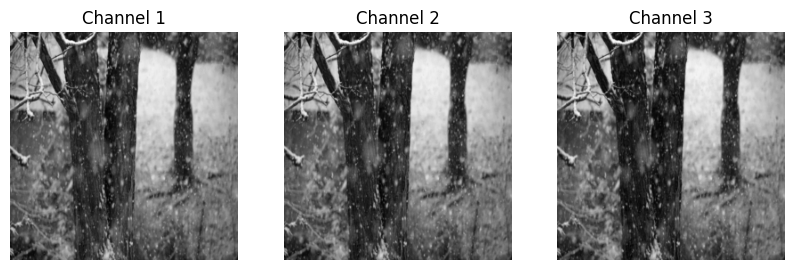

In [64]:
keshihua(k)

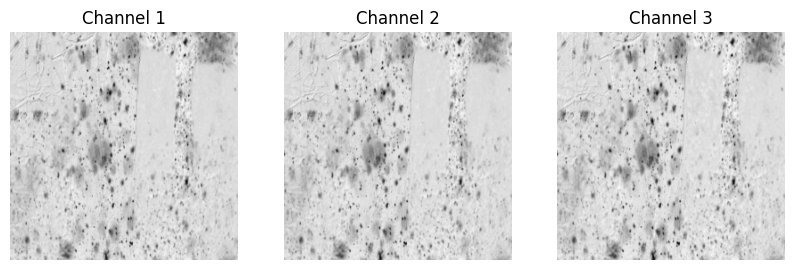

In [65]:
keshihua(resn.squeeze(0))


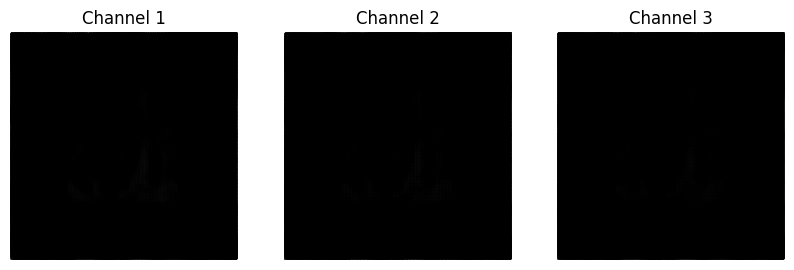

In [66]:
keshihua(x.squeeze(0))

In [62]:
print(x[0][0][1][:10])
print(resn[0][0][1][:10])

tensor([3.5182e-02, 4.5579e-04, 3.6046e-03, 2.2207e-04, 4.7597e-05, 3.0352e-05,
        6.9378e-04, 8.8491e-05, 1.7076e-05, 1.1525e-05],
       grad_fn=<SliceBackward0>)
tensor([-0.0078,  0.0000, -0.0078, -0.0549, -0.0471,  0.0549,  0.1020,  0.0078,
        -0.0078,  0.0157])


# # # ***test_model***

In [ ]:
torch.cuda.empty_cache()
device="cuda"
vae = VAE().to(device)
input_tensor = torch.randn(64, 3, 256, 256).to(device)
output_tensor,class_tp,embed_tp = vae(input_tensor)
print(output_tensor.shape)
print(class_tp.shape)
print(embed_tp.shape)
print(f"显存使用 (分配): {torch.cuda.memory_allocated(device) / 1024 ** 2:.2f} MB")
print(f"显存使用 (保留): {torch.cuda.memory_reserved(device) / 1024 ** 2:.2f} MB")

In [ ]:
del(vae)
del(input_tensor)

# # # ***Train Officially***

In [4]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

***lr hanshu***

In [8]:
epoch=0
max_epoch=100
dataset=train_load(batch_size=32)
val_data=train_load(batch_size=32,train=False)
net=VAE()
device="cuda"
optimizer=optim.Adam(net.parameters(),lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
##load_checkpoint
"""
path="/kaggle/input/train-4ep/latest"
with open(path, "rb") as f:
    state=torch.load(f, map_location="cpu")
net.load_state_dict(state["model"])
"""
Mse_loss=nn.MSELoss()
Gp_loss=nn.CrossEntropyLoss()
lambda_recon = 0.8
lambda_cls = 0.2
exp_name="vae"
os.makedirs("./{}".format(exp_name))

net.to(device)
net.train()
while(epoch<max_epoch):
    phar=tqdm(total=len(dataset))
    loss_avg=0
    z = get_lr(optimizer)
    for step,(resn,input_img,label) in enumerate(dataset):
        x=resn
        x=x.to(device)
        label=label.view(-1).to(device)
        optimizer.zero_grad()
        
        x_recon,pred_label,embed=net(x)
        loss1=Mse_loss(x,x_recon)
        loss2=Gp_loss(pred_label,label)
        
        loss=loss1
        loss_avg=(loss_avg*step+loss)/(step+1)
        loss.backward()
        optimizer.step()
        phar.set_description(
            "epoch:{} loss:{:.4f} mse_loss:{:.4f} class_loss:{:.4f} lr:{}".format(epoch, loss_avg,loss1,loss2,z ))
        phar.update()
        """
        try:
            if(step%51==0):
                print(pred_label[:10])
                print(label[:10])
        except:
            pass
        """
    phar.close()
    
    loss_avg=0
    loss_cls=0
    loss_recon=0
    phar=tqdm(total=len(val_data))
    net.eval()
    with torch.no_grad():
        for step,(resn,input_img,label) in enumerate(val_data):
            x=resn
            x=x.to(device)
            label=label.view(-1).to(device)

            x_recon,pred_label,embed=net(x)
            loss1=Mse_loss(x,x_recon)
            loss2=Gp_loss(pred_label,label)
            loss_cls=(loss_cls*step+loss1)/(step+1)
            loss_recon=(loss_recon*step+loss2)/(step+1)
            loss=loss1
            loss_avg=(loss_avg*step+loss)/(step+1)
            phar.set_description(
            "Val: loss:{:.4f} mse_loss:{:.4f} class_loss:{:.4f} ".format( loss_avg,loss_recon,loss_cls ))
            phar.update()
    phar.close()
    epoch+=1
    state = {
        "epoch": epoch,
        "model": net.state_dict(),
        "loss1": loss1,
        "loss2":loss_avg,
    }
    scheduler.step()
        
    with open('./{}/latest'.format(exp_name), "wb") as f:
        torch.save(state, f)
    
    
    

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for step,(resn,gt,label) in enumerate(dataset):
    print(label.shape)

# # # ***Produse path***

In [ ]:
os.makedirs("./temp")
state=torch.Tensor([1])
with open('./{}/latest'.format("temp"), "wb") as f:
        torch.save(state, f)

In [7]:
os.rmdir("/kaggle/working/vae")